In [1]:
import pandas as pd
from gurobipy import *
import gurobipy as grbpy
import numpy as np

In [2]:
# importing the generators data (gives information about individual generators - type of fuel used, max power and unit cost)
generators_dataframe = pd.read_csv("generators.csv")
generators_dataframe = generators_dataframe.reset_index(drop = True)
generators_dataframe = generators_dataframe.dropna()
generators_dataframe['generator'] = generators_dataframe['generator'].astype(int)
generators_dataframe['bus'] = generators_dataframe['bus'].astype(int)
generators_dataframe

,generator,bus,fuel,pmax,sigma
0,0,10,nuclear,12.990000,412.00
1,1,11,nuclear,10.120000,412.00
2,2,12,rfo,-0.000000,7609.72
3,3,12,rfo,-0.000000,7609.72
4,4,13,rfo,-0.000000,7553.20
...,...,...,...,...,...
390,390,1414,wind,0.134960,0.00
391,391,1416,wind,0.181370,0.00
392,392,1483,wind,0.000213,0.00
393,393,1669,wind,0.079979,0.00


In [3]:
# importing the buses data (gives information about the nodes - load that each node can carry)
buses_dataframe = pd.read_csv('buses.csv')
buses_dataframe = buses_dataframe.reset_index(drop = True)
buses_dataframe = buses_dataframe.dropna()
buses_dataframe['bus'] = buses_dataframe['bus'].astype(int)
buses_dataframe

,bus,load
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
1809,1809,0.000000
1810,1810,0.000000
1811,1811,0.000000
1812,1812,0.084839


In [4]:
# importing the branches data (gives information about the branches - nodes at the end of a branch, reactance and branch limit)
branches_dataframe = pd.read_csv('branches.csv')
branches_dataframe = branches_dataframe.reset_index(drop = True)
branches_dataframe = branches_dataframe.dropna()
branches_dataframe['branch'] = branches_dataframe['branch'].astype(int)
branches_dataframe['from'] = branches_dataframe['from'].astype(int)
branches_dataframe['to'] = branches_dataframe['to'].astype(int)
branches_dataframe

,branch,from,to,x,u
0,0,0,335,0.076440,2.19
1,1,1,40,0.086740,2.84
2,2,2,1704,0.049563,7.94
3,3,3,1641,0.008770,4.76
4,4,4,1482,0.188510,2.19
...,...,...,...,...,...
2198,2198,1756,1757,0.015570,7.00
2199,2199,1759,1760,0.012822,8.50
2200,2200,1764,1765,0.011473,9.50
2201,2201,1794,1795,0.009477,11.50


In [5]:
# F(i) : branches which start from node 'i'
# T(i) : branches which end at node 'i'
# It takes node name as an input argument and gives branch ending and branch starting at that node as output
def get_branches_associated_with_node(node):
    branch_ending_at_node = branches_dataframe[branches_dataframe['to'] == node]
    branch_starting_from_node = branches_dataframe[branches_dataframe['from'] == node]
    branch_starting_from_node.reset_index(drop = True, inplace = True)
    branch_ending_at_node.reset_index(drop = True, inplace = True)
    return branch_ending_at_node['branch'], branch_starting_from_node['branch'] 

In [6]:
# Gives the nodes that connect a branch
# It takes branch name as an input argument and gives nodes at the start and at the end of that branch as output
def get_nodes_info_from_branch(branch):
    nodes = branches_dataframe[branches_dataframe['branch'] == branch]
    nodes.reset_index(drop = True, inplace = True)
    return nodes['from'][0], nodes['to'][0]

In [7]:
# G(i) : generators located at a particular node
# It takes node name as an input argument and gives list of generators at that node
def get_all_generators_at_node(node):
    generators = generators_dataframe[generators_dataframe['bus'] == node]
    generators.reset_index(drop = True, inplace = True)
    return generators['generator']

In [8]:
# Sigma (unit cost) of a generator
# It takes generator name as an input argument and gives unit cost (sigma) of the generator as output
def get_unit_cost_of_generator(generator):
    generator_unit_cost = generators_dataframe[generators_dataframe['generator'] == generator]
    generator_unit_cost.reset_index(drop = True, inplace = True)

    return generator_unit_cost["sigma"][0]

In [9]:
# Load at a particular node
# It takes node name as an input argument and gives load at that node as output
def get_load_at_node(node):
    load = buses_dataframe[buses_dataframe['bus'] == node]
    load.reset_index(drop = True, inplace = True)
    load = load[' load'][0]
    return load

In [10]:
# Max power capacity of a generator
# It takes generator name as input argument and gives max power generated by a generator as output
def get_max_power_from_generator(generator):
    max_power = generators_dataframe[generators_dataframe['generator'] == generator]
    max_power.reset_index(drop = True, inplace = True)
    max_power = max_power['pmax']
    max_power = abs(max_power.values[0]) # To get rid of negative values
    
    return max_power%

In [11]:
# Branch limit (max power flow) for a branch
# It takes branch name as an input argument and gives branch limit as output
def get_max_power_flow_through_branch(branch):
    df = branches_dataframe[branches_dataframe['branch'] == branch]
    df.reset_index(drop = True, inplace = True)
    branch_limit = df["u"].values[0]

    return branch_limit

In [12]:
# Reactance (x) for a particular branch
# It takes branch name as an input argument and gives branch reactance as output
def get_reactance_of_branch(branch):
    reactance = branches_dataframe[branches_dataframe['branch'] == branch]
    reactance.reset_index(drop = True, inplace = True)
    branch_reactance = reactance['x'].values[0]
    return branch_reactance

In [13]:
# Power flow through a branch
# It takes branch name and phase angle as arguments and gives power through a branch as output
# It also uses branch reactance computed from function defined above to give the power flow
def get_power_flow_through_a_branch(branch, phase_angle_i, phase_angle_j):
    reactance = get_reactance_of_branch(branch)
    power = (phase_angle_i - phase_angle_j)*(1/reactance)
    return power

## Component 1 : Part 1

Steps to create Component 1 : Part 1
1. Initialising the model 

2. Adding variables (Variables are power through a branch, phase angle (θ) and generation units (Γ))
- We initialise the dictionary for each of the above variables
- Key of the dictionary is the name of the variable (For example : for 'power' variable, power_ + branch name (power_0 for branch '0'). Similarly, phase_angle_0 for node '0' and gamma_0 for generator named '0'
- Value of the dictionary are the variables to be identified that would optimise the objective function.

3. Defining objective function
- Σg (σgΓg) (Sum of unit cost of generator (σ) and generation units (Γ) of each generator)


4. Defining target (Maximise / Minimise)
- Minimising the above objective function

5. Adding Constraints <br>
a) 0 ≤ Γg ≤ pmaxg (generation units should be less than max power capacity of the generator) <br>
b) pb = (θi−θj)/xb (power through a branch equals difference in phases at end nodes of the branch divided by the branch reactance) <br>
c) |pb| ≤ ub (power flow through a branch is less than the branch limit) <br>
d) Σ pb ( b  ∈  F (i) ) − Σ pb  ( b  ∈  T(i) ) = Σ ( g  ∈  G(i) )   Γg − di <br>
(net amount of power injected by the bus i into the system is constant)


6. Run the Model (Optimise)

7. Print Model Status (2 is Optimal)

8. Print decision variables (Power through a branch, phase angle (θ) and generation units (Γ))

9. Print objective function value

In [14]:
from gurobipy import *

try:

    # STEP 1 : Create a new model
    m = Model('Component 1 : Part 1')
    m.Params.Method = -1
    m.params.NonConvex = -1
    
    # STEP 2: Adding variables
    branches_list = set(branches_dataframe['branch'].values)
    power = dict()
    for branch in branches_list:
        power[branch] = m.addVar(vtype = GRB.CONTINUOUS, name = 'power_' + str(branch), lb = -GRB.INFINITY)
        
    nodes_list = set(buses_dataframe['bus'].values)
    phase_angle = dict()
    for node in nodes_list:
        phase_angle[node] = m.addVar(vtype = GRB.CONTINUOUS, name = 'phase_angle_' + str(node), lb = -GRB.INFINITY)
    
    generators_list = set(generators_dataframe['generator'].values)
    generation_units = dict()
    
    for generator_ in generators_list:
        generation_units[generator_] = m.addVar(vtype = GRB.CONTINUOUS, name = 'gamma_' + str(generator_))

    # Integrate new variables
    m.update()

    # STEP 3 : Defining objective function
    cost_per_generator_list = [get_unit_cost_of_generator(g) * generation_units[g] for g in generators_list]
    objective = sum(cost_per_generator_list)
    
    # STEP 4 : Defining target
    m.setObjective(objective, GRB.MINIMIZE)

    
    # STEP 5 : Adding Constraints
    
    # STEP 5a
    for generator_ in generators_list:
        m.addConstr(generation_units[generator_] <= get_max_power_from_generator(generator_), name = 'max_power_' + str(generator_))
    
    # STEP 5b
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] == get_power_flow_through_a_branch(branch, phase_angle_i, phase_angle_j), name = 'power_flow_' + str(branch))

    # STEP 5c
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] <= get_max_power_flow_through_branch(branch), name = 'branch_limit_pos' + str(branch))
        m.addConstr(power[branch] >= -get_max_power_flow_through_branch(branch), name = 'branch_limit_neg' + str(branch))

    # STEP 5d
    for node in nodes_list:
        from_branches = get_branches_associated_with_node(node)[1]
        from_power = [power[branch] for branch in from_branches]
        to_branches = get_branches_associated_with_node(node)[0]
        to_power = [power[branch] for branch in to_branches]
        generators = get_all_generators_at_node(node)

        m.addConstr(sum(from_power) - sum(to_power) == sum([generation_units[generator_] for generator_ in generators]) - get_load_at_node(node), name = 'power_balance_' + str(node))

    
    # STEP 6 : Optimize (model is updated when we optimize)
    m.optimize()

    # STEP 7 : Print model status (2 is optimal)
    #https://www.gurobi.com/documentation/6.5/refman/optimization_status_codes.html
    print('Model status: ' + str(m.status))

    # STEP 8 : Print decision variables
    for v in m.getVars():
        try:
            print(v.varName + ' = ' + str(v.x))
        except:
            continue

    # STEP 9 : print objective function value
    try:
        print('Obj: ' + str(m.objVal))
    except:
        print('Looks like the model is not feasible')

except GurobiError:
    print('Error reported')

Academic license - for non-commercial use only - expires 2022-09-25
Using license file /Users/harshal/gurobi.lic
Parameter Method unchanged
   Value: -1  Min: -1  Max: 5  Default: -1
Parameter NonConvex unchanged
   Value: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8818 rows, 4412 columns and 16211 nonzeros
Model fingerprint: 0xf5bcb2ce
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 8e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 5335 rows and 586 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds
Infeasible model
Model status: 3
Looks like the model is not feasible


## Component 1 : Part 2

Steps to create Component 1 : Part 2
1. Initialising the model 

2. Adding variables (Variables are power through a branch, phase angle (θ), generation units (Γ) and shed (S))
- We initialise the dictionary for each of the above variables
- Key of the dictionary is the name of the variable (For example : for 'power' variable, power_ + branch name (power_0 for branch '0'). Similarly, phase_angle_0 for node '0' and gamma_0 for generator named '0'
- Value of the dictionary are the variables to be identified that would optimise the objective function.

3. Defining objective function
- Σg (σgΓg) + 10^6 Σi Si (Sum of unit cost of generator (σ) and generation units (Γ) of each generator)


4. Defining target (Maximise / Minimise)
- Minimising the above objective function

5. Adding Constraints <br>
a) 0 ≤ Γg ≤ pmaxg (generation units should be less than max power capacity of the generator) <br>
b) pb = (θi−θj)/xb (power through a branch equals difference in phases at end nodes of the branch divided by the branch reactance) <br>
c) |pb| ≤ ub (power flow through a branch is less than the branch limit) <br>
d) Σ pb ( b  ∈  F (i) ) − Σ pb  ( b  ∈  T(i) ) = Σ ( g  ∈  G(i) )   Γg − (di−Si) <br>
(net amount of power injected by the bus i into the system is constant) <br>
e) 0 ≤ Si ≤ di


6. Run the Model (Optimise)

7. Print Model Status (2 is Optimal)

8. Print decision variables (Power through a branch, phase angle (θ) and generation units (Γ))

9. Print objective function value

In [15]:
from gurobipy import *

try:

    # STEP 1 : Create a new model
    m = Model('Component 1 : Part 2')
    m.Params.Method = -1
    m.params.NonConvex = -1
    
    # STEP 2: Adding variables
    branches_list = set(branches_dataframe['branch'].values)
    power = dict()
    for branch in branches_list:
        power[branch] = m.addVar(vtype = GRB.CONTINUOUS, name = 'power_' + str(branch), lb = -GRB.INFINITY)
        
    nodes_list = set(buses_dataframe['bus'].values)
    phase_angle = dict()
    for node in nodes_list:
        phase_angle[node] = m.addVar(vtype = GRB.CONTINUOUS, name = 'phase_angle_' + str(node), lb = -GRB.INFINITY)
    
    generators_list = set(generators_dataframe['generator'].values)
    generation_units = dict()
    
    for generator_ in generators_list:
        generation_units[generator_] = m.addVar(vtype = GRB.CONTINUOUS, name = 'gamma_' + str(generator_))
        
    shed = dict()
    for node in nodes_list:
        shed[node] = m.addVar(name = 'shed_' + str(node))

    # Integrate new variables
    m.update()

    # STEP 3 : Defining objective function
    cost_per_generator_list = [get_unit_cost_of_generator(g)*generation_units[g] for g in generators_list]
    shed_at_nodes = [shed[node] for node in nodes_list]
    objective = sum(cost_per_generator_list) + 1e6*sum(shed_at_nodes)
    
    # STEP 4 : Defining target
    m.setObjective(objective, GRB.MINIMIZE)

    
    # STEP 5 : Adding Constraints
    
    # STEP 5a
    for generator_ in generators_list:
        m.addConstr(generation_units[generator_] <= get_max_power_from_generator(generator_), name = 'max_power_' + str(generator_))
    
    # STEP 5b
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] == get_power_flow_through_a_branch(branch, phase_angle_i, phase_angle_j), name = 'power_flow_' + str(branch))

    # STEP 5c
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] <= get_max_power_flow_through_branch(branch), name = 'branch_limit_pos' + str(branch))
        m.addConstr(power[branch] >= -get_max_power_flow_through_branch(branch), name = 'branch_limit_neg' + str(branch))

    # STEP 5d
    for node in nodes_list:
        from_branches = get_branches_associated_with_node(node)[1]
        from_power = [power[branch] for branch in from_branches]
        to_branches = get_branches_associated_with_node(node)[0]
        to_power = [power[branch] for branch in to_branches]
        generators = get_all_generators_at_node(node)

        m.addConstr(sum(from_power) - sum(to_power) == sum([generation_units[generator_] for generator_ in generators]) - (get_load_at_node(node) - shed[node]), name = 'power_balance_' + str(node))
        
    # STEP 5e : Additional shed constraint
    for node in nodes_list:
        m.addConstr(shed[node] <= get_load_at_node(node), name = 'shed_const_' + str(node))

    
    # STEP 6 : Optimize (model is updated when we optimize)
    m.optimize()

    # STEP 7 : Print model status (2 is optimal)
    #https://www.gurobi.com/documentation/6.5/refman/optimization_status_codes.html
    print('Model status: ' + str(m.status))

    # STEP 8 : Print decision variables
    for v in m.getVars():
        try:
            print(v.varName + ' = ' + str(v.x))
        except:
            continue

    # STEP 9 : print objective function value
    try:
        print('Obj: ' + str(m.objVal))
    except:
        print('Looks like the model is not feasible')

except GurobiError:
    print('Error reported')

Parameter Method unchanged
   Value: -1  Min: -1  Max: 5  Default: -1
Parameter NonConvex unchanged
   Value: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xa5192303
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3679 columns
Presolve time: 0.02s
Presolved: 1130 rows, 2547 columns, 6866 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     972    6.0867330e+05   0.000000e+00   0.000000e+00      0s

Solved in 972 iterations and 0.14 seconds
Optimal objective  6.086733029e+05
Model status: 2
power_0 = 0.0
power_1 = 0.0
power_2 = 0.0
power_3 = 0.0
power_4 = 0.

In [16]:
# Importing the scaled covariance data
covariance_dataframe = pd.read_csv('scaledcov.txt', sep = ' ', header = None)
covariance_dataframe = covariance_dataframe.loc[:, covariance_dataframe.columns != 0]
covariance_dataframe.columns = [column_name for column_name in range(len(covariance_dataframe))]

# wind_dataframe is mask applied to generators_dataframe having generators info where fuel is 'wind'
wind_dataframe = generators_dataframe[generators_dataframe['fuel'] == 'wind']
wind_dataframe.reset_index(drop = True, inplace = True)

In [17]:
# Generate sample output for wind generator everytime the function is called
def sample_output_for_wind_generator():
    from numpy.random import default_rng # from documentation (legacy version is np.random.multivariate_normal)
    rng = default_rng() # new version
    sample = rng.multivariate_normal(mean = np.array(wind_dataframe['pmax']), cov = np.array(covariance_dataframe), size = None, check_valid = 'warn')
    sample = np.where(sample > 0, sample, 0) # To avoid negative output
    return sample

In [18]:
# Get shadow price of node i and Optimal dual variable for constraint 5d
def get_shadow_price_and_shed(model):
    shadow_price_dictionary = dict()
    shed_dictionary = dict()
    for constraint in model.getConstrs():
        if 'power_balance_' in constraint.constrName:
            node = constraint.constrName.split('_')[2]
            node = int(node)
            shadow_price_node = constraint.pi
            shadow_price_dictionary[node] = -shadow_price_node
        
    for var in model.getVars():
        if 'shed_' in var.varname:
            node = var.varname.split('_')[1]
            node = int(node)
            s = var.x
            shed_dictionary[node] = s

    return shadow_price_dictionary, shed_dictionary

## Component 2

Steps to create Component 2:
1. Initialising the model 

2. Adding variables (Variables are power through a branch, phase angle (θ), generation units (Γ) and shed (S))
- We initialise the dictionary for each of the above variables
- Key of the dictionary is the name of the variable (For example : for 'power' variable, power_ + branch name (power_0 for branch '0'). Similarly, phase_angle_0 for node '0' and gamma_0 for generator named '0'
- Value of the dictionary are the variables to be identified that would optimise the objective function.

3. Defining objective function
- Σg (σgΓg) + 10^6 Σi Si (Sum of unit cost of generator (σ) and generation units (Γ) of each generator)


4. Defining target (Maximise / Minimise)
- Minimising the above objective function

5. Adding Constraints <br>
a) 0 ≤ Γg ≤ pmaxg (Constraint is skipped if generator is 'wind' operated) <br>
(generation units should be less than max power capacity of the generator) <br>
b) pb = (θi−θj)/xb (power through a branch equals difference in phases at end nodes of the branch divided by the branch reactance) <br>
c) |pb| ≤ ub (power flow through a branch is less than the branch limit) <br>
d) Σ pb ( b  ∈  F (i) ) − Σ pb  ( b  ∈  T(i) ) = Σ ( g  ∈  G(i) )   Γg − (di−Si) <br>
(net amount of power injected by the bus i into the system is constant) <br>
e) 0 ≤ Si ≤ di

In [19]:
from gurobipy import *

try:

    # STEP 1 : Create a new model
    m = Model('Component 2')
    m.Params.LogToConsole = 0
    m.Params.Method = -1
    m.params.NonConvex = -1
    
    # STEP 2: Adding variables
    branches_list = set(branches_dataframe['branch'].values)
    power = dict()
    for branch in branches_list:
        power[branch] = m.addVar(vtype = GRB.CONTINUOUS, name = 'power_' + str(branch), lb = -GRB.INFINITY)
        
    nodes_list = set(buses_dataframe['bus'].values)
    phase_angle = dict()
    for node in nodes_list:
        phase_angle[node] = m.addVar(vtype = GRB.CONTINUOUS, name = 'phase_angle_' + str(node), lb = -GRB.INFINITY)
    
    generators_list = set(generators_dataframe['generator'].values)
    generation_units = dict()
    
    for generator_ in generators_list:
        generation_units[generator_] = m.addVar(vtype = GRB.CONTINUOUS, name = 'gamma_' + str(generator_))
        
    shed = dict()
    for node in nodes_list:
        shed[node] = m.addVar(name = 'shed_' + str(node))
        
    # Using the dataframe created above and returning array of generators names having fuel as 'wind'
    wind_generators_array = np.array(wind_dataframe['generator'])

    # Integrate new variables
    m.update()

    # STEP 3 : Defining objective function
    cost_per_generator_list = [get_unit_cost_of_generator(g)*generation_units[g] for g in generators_list]
    shed_at_nodes = [shed[node] for node in nodes_list]
    objective = sum(cost_per_generator_list) + 1e6*sum(shed_at_nodes)
    
    # STEP 4 : Defining target
    m.setObjective(objective, GRB.MINIMIZE)

    
    # STEP 5 : Adding Constraints
    
    # STEP 5a
    for generator_ in generators_list:
        if generator_ in wind_generators_array: # The Skipping Portion
            continue
            
        m.addConstr(generation_units[generator_] <= get_max_power_from_generator(generator_), name = 'max_power_' + str(generator_))
    
    # STEP 5b
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] == get_power_flow_through_a_branch(branch, phase_angle_i, phase_angle_j), name = 'power_flow_' + str(branch))

    # STEP 5c
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] <= get_max_power_flow_through_branch(branch), name = 'branch_limit_pos' + str(branch))
        m.addConstr(power[branch] >= -get_max_power_flow_through_branch(branch), name = 'branch_limit_neg' + str(branch))

    # STEP 5d
    for node in nodes_list:
        from_branches = get_branches_associated_with_node(node)[1]
        from_power = [power[branch] for branch in from_branches]
        to_branches = get_branches_associated_with_node(node)[0]
        to_power = [power[branch] for branch in to_branches]
        generators = get_all_generators_at_node(node)

        m.addConstr(sum(from_power) - sum(to_power) == sum([generation_units[generator_] for generator_ in generators]) - (get_load_at_node(node) - shed[node]), name = 'power_balance_' + str(node))
        
    # STEP 5e : Additional shed constraint
    for node in nodes_list:
        m.addConstr(shed[node] <= get_load_at_node(node), name = 'shed_const_' + str(node))

except GurobiError:
    print('Error reported')

### Generating Samples

In [20]:
# Save costs to csv file
# Skip if reading costs from csv file

from tqdm import tqdm # For creating progress meters / progress bars

n = 1000
costs = []
nodes_list = buses_dataframe["bus"].unique()#set(buses_dataframe['bus'].values)
#bar = progressbar.ProgressBar(maxval = n).start()

pbar = tqdm(total = n)
while len(costs) < n:
    sample_wind = sample_output_for_wind_generator()
    for i, g in enumerate(wind_generators_array):
        generation_units[g].lb = sample_wind[i]
        generation_units[g].ub = sample_wind[i]

    m.update()
    m.optimize()

    # Check if model is feasible
    if m.status != 2:
        continue

    pi = get_shadow_price_and_shed(m)[0]
    shed_0 = get_shadow_price_and_shed(m)[1]
    
    cost = sum([pi[node] * (get_load_at_node(node) - shed_0[node]) for node in nodes_list])
    costs.append(cost)
    pbar.update(1)

costs_array = np.array(costs)
np.savetxt('costs.csv', costs_array, delimiter = ' ', header = 'cost', comments = '')

100%|██████████| 1000/1000 [13:11<00:00,  1.13it/s]

/Users/harshal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

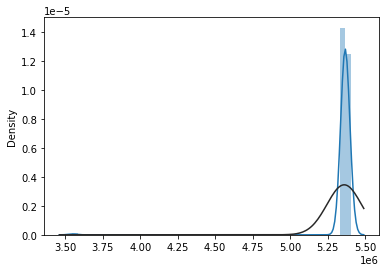

In [21]:
import seaborn as sns
from scipy.stats import norm, gamma
sns.distplot(costs_array, fit = norm)

In [22]:
costs_dataframe = pd.read_csv('costs.csv', delimiter = ' ')
costs_dataframe

,cost
0,5.392408e+06
1,5.361020e+06
2,5.392575e+06
3,5.361020e+06
4,5.359948e+06
...,...
995,5.375951e+06
996,5.357208e+06
997,5.357459e+06
998,5.365181e+06


/Users/harshal/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cost'>

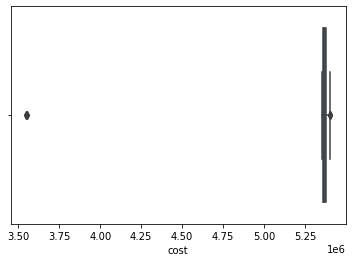

In [23]:
# Detecting the outliers
import seaborn as sns
sns.boxplot(costs_dataframe['cost'])

In [24]:
# Position of the Outlier
print(np.where(costs_dataframe['cost'] < 5250000))

(array([191, 281, 547, 766]),)


In [25]:
# Removing the outliers
outliers_list = np.where(costs_dataframe['cost'] < 5250000)
costs_dataframe = costs_dataframe.drop(list(outliers_list[0]))             
costs_dataframe

,cost
0,5.392408e+06
1,5.361020e+06
2,5.392575e+06
3,5.361020e+06
4,5.359948e+06
...,...
995,5.375951e+06
996,5.357208e+06
997,5.357459e+06
998,5.365181e+06


/Users/harshal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cost', ylabel='Density'>

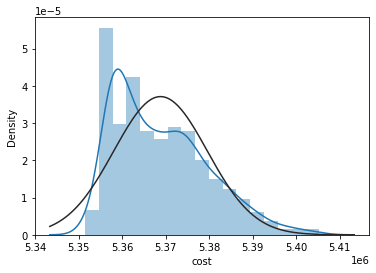

In [26]:
# New Plot after removing outliers
import seaborn as sns
from scipy.stats import norm, gamma
sns.distplot(costs_dataframe['cost'], fit = norm)

## Distribution Fitting

- For distribution fitting we shall use the Fitter package. 
- Fitter provides a simple class to identify the distribution from which a data samples is generated from. It uses 80 distributions from Scipy and allows you to plot the results to check what is the most probable distribution and the best parameters.
- Reference: https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9
https://fitter.readthedocs.io/en/latest/

In [10]:
filename='costs.csv'

In [11]:
import pandas as pd
df=pd.read_csv(filename)
df.head()

,cost
0,5.392408e+06
1,5.361020e+06
2,5.392575e+06
3,5.361020e+06
4,5.359948e+06


,sumsquare_error,aic,bic,kl_div
cauchy,1.290635e-10,3.799848e+03,-29664.656653,inf
norm,1.004543e-09,1.056632e+04,-27612.672507,inf
expon,1.271003e-09,2.988657e+03,-27377.399331,inf
chi2,1.279972e-09,inf,-27363.459371,NaN
lognorm,1.288937e-09,3.452717e+03,-27356.479696,inf


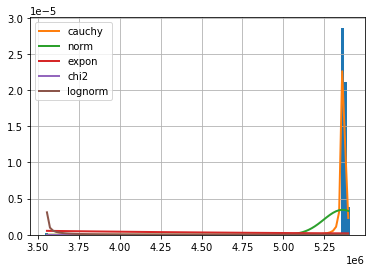

In [12]:
#use fitter to fit the distribution of the raw data of costs 
from scipy import stats

from fitter import Fitter
f = Fitter(df['cost'],distributions=['cauchy',
 'chi2',
 'norm',
 'expon',
 'lognorm'])
f.fit()
f.summary()

- The cost distribution has outliers skewing and hampering the distribution fitting. So we need to remove the outliers.

In [13]:
import seaborn as sns
import numpy as np
from scipy.stats import norm, gamma

In [14]:
df_costs = pd.read_csv(filename, delimiter = ' ')
df_costs.head()

,cost
0,5.392408e+06
1,5.361020e+06
2,5.392575e+06
3,5.361020e+06
4,5.359948e+06


In [15]:
#removing outliers
outliers_list = np.where(df_costs['cost'] < 5250000)
df_costs = df_costs.drop(list(outliers_list[0]))             
df_costs

,cost
0,5.392408e+06
1,5.361020e+06
2,5.392575e+06
3,5.361020e+06
4,5.359948e+06
...,...
995,5.375951e+06
996,5.357208e+06
997,5.357459e+06
998,5.365181e+06


/Users/suhanimishra/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cost', ylabel='Density'>

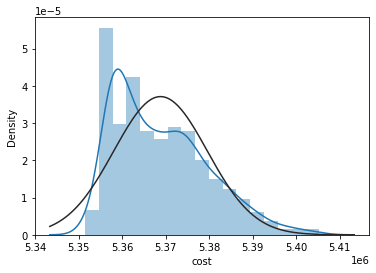

In [16]:
#plotting with outliers removed
sns.distplot(df_costs['cost'], fit = norm)
#np.savetxt('costsfinal.csv', costs_array1, delimiter = ' ', header = 'cost', comments = '')

,sumsquare_error,aic,bic,kl_div
norm,5.571828e-08,2330.838422,-23498.470446,inf
cauchy,6.002141e-08,2334.330413,-23424.374973,inf
expon,6.431492e-08,2265.987976,-23355.561005,inf
chi2,1.035894e-07,inf,-22873.920867,3.645651
lognorm,1.284829e-07,2674.287410,-22659.420799,inf


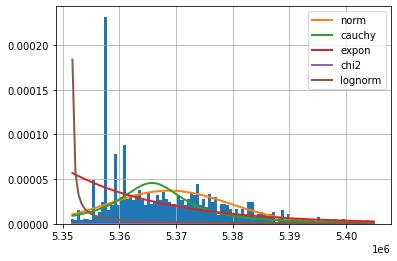

In [17]:
#We see if the distribution fits a few common ones before running a more extensive analysis 
f = Fitter(df_costs['cost'],distributions=['cauchy', 'chi2', 'norm', 'expon', 'lognorm'])
f.fit()
f.summary()

### The cost data appears to have a normal distribution as compared to the other common distributions (Cauchy, Exponential, Chi Squared, Lognormal)

,sumsquare_error,aic,bic,kl_div
laplace_asymmetric,4.314127e-08,2293.592752,-23746.371575,inf
exponnorm,4.725126e-08,2288.509538,-23655.736447,inf
skewnorm,4.738685e-08,2289.662294,-23652.882510,inf
johnsonsb,4.876266e-08,2285.561183,-23617.472961,inf
erlang,4.969688e-08,2285.018421,-23605.475421,inf


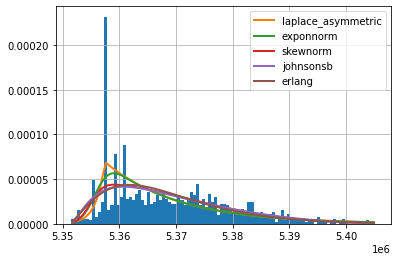

/Users/suhanimishra/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


In [18]:
#Fitter runs an analysis with 80 distribution supported by the scipy library
f = Fitter(df_costs['cost'])
f.fit()
f.summary()

### We used 80 distributions from Scipy and plotted the results and Exponential Normal appears to be the most probable distribution. Exponential Distribution is also known as Exponentially Modified Gaussian Distribution, and it is the sum of independent normal and exponential random variables.

## Extra Credit

- Value at Risk measures the worst expected loss over a given horizon under normal market conditions at a given level of confidence.

- In the variance-covariance approach we use a parametric methodology where returns are assumed as normally distributed. Therefore we need to calculate just two parameters, mean and SD (i.e. Standard Deviation) of the given returns.

- Reference : https://blog.quantinsti.com/calculating-value-at-risk-in-excel-python/  <br>
https://levelup.gitconnected.com/value-at-risk-with-python-d87cf6c41ed1

### Calculating Value at Risk

/Users/harshal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


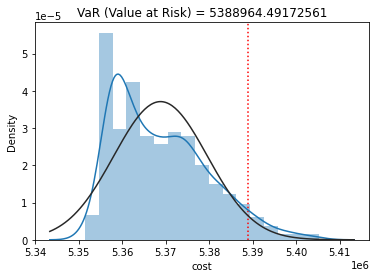

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.axvline(np.percentile(np.sort(costs_dataframe['cost']), 95), color = 'red', linestyle = 'dotted')
cost_array_series = pd.Series(costs_dataframe['cost'], name = 'cost')
sns.distplot(cost_array_series, fit = norm)
plt.title('VaR (Value at Risk) = ' + str(np.percentile(np.sort(costs_dataframe['cost']), 95)))
plt.show()

### Running the Component 1 : Part 2 again for (b) part of extra credit

In [28]:
from gurobipy import *

try:

    # STEP 1 : Create a new model
    m = Model('Component 1 : Part 2')
    m.Params.Method = -1
    m.params.NonConvex = -1
    
    # STEP 2: Adding variables
    branches_list = set(branches_dataframe['branch'].values)
    power = dict()
    for branch in branches_list:
        power[branch] = m.addVar(vtype = GRB.CONTINUOUS, name = 'power_' + str(branch), lb = -GRB.INFINITY)
        
    nodes_list = set(buses_dataframe['bus'].values)
    phase_angle = dict()
    for node in nodes_list:
        phase_angle[node] = m.addVar(vtype = GRB.CONTINUOUS, name = 'phase_angle_' + str(node), lb = -GRB.INFINITY)
    
    generators_list = set(generators_dataframe['generator'].values)
    generation_units = dict()
    
    for generator_ in generators_list:
        generation_units[generator_] = m.addVar(vtype = GRB.CONTINUOUS, name = 'gamma_' + str(generator_))
        
    shed = dict()
    for node in nodes_list:
        shed[node] = m.addVar(name = 'shed_' + str(node))

    # Integrate new variables
    m.update()

    # STEP 3 : Defining objective function
    cost_per_generator_list = [get_unit_cost_of_generator(g)*generation_units[g] for g in generators_list]
    shed_at_nodes = [shed[node] for node in nodes_list]
    objective = sum(cost_per_generator_list) + 1e6*sum(shed_at_nodes)
    
    # STEP 4 : Defining target
    m.setObjective(objective, GRB.MINIMIZE)

    
    # STEP 5 : Adding Constraints
    
    # STEP 5a
    for generator_ in generators_list:
        m.addConstr(generation_units[generator_] <= get_max_power_from_generator(generator_), name = 'max_power_' + str(generator_))
    
    # STEP 5b
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] == get_power_flow_through_a_branch(branch, phase_angle_i, phase_angle_j), name = 'power_flow_' + str(branch))

    # STEP 5c
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] <= get_max_power_flow_through_branch(branch), name = 'branch_limit_pos' + str(branch))
        m.addConstr(power[branch] >= -get_max_power_flow_through_branch(branch), name = 'branch_limit_neg' + str(branch))

    # STEP 5d
    for node in nodes_list:
        from_branches = get_branches_associated_with_node(node)[1]
        from_power = [power[branch] for branch in from_branches]
        to_branches = get_branches_associated_with_node(node)[0]
        to_power = [power[branch] for branch in to_branches]
        generators = get_all_generators_at_node(node)

        m.addConstr(sum(from_power) - sum(to_power) == sum([generation_units[generator_] for generator_ in generators]) - (get_load_at_node(node) - shed[node]), name = 'power_balance_' + str(node))
        
    # STEP 5e : Additional shed constraint
    for node in nodes_list:
        m.addConstr(shed[node] <= get_load_at_node(node), name = 'shed_const_' + str(node))

    
    # STEP 6 : Optimize (model is updated when we optimize)
    m.optimize()

    # STEP 7 : Print model status (2 is optimal)
    #https://www.gurobi.com/documentation/6.5/refman/optimization_status_codes.html
    print('Model status: ' + str(m.status))

    # STEP 8 : Print decision variables
    for v in m.getVars():
        try:
            print(v.varName + ' = ' + str(v.x))
        except:
            continue

    # STEP 9 : print objective function value
    try:
        print('Obj: ' + str(m.objVal))
    except:
        print('Looks like the model is not feasible')

except GurobiError:
    print('Error reported')

Parameter Method unchanged
   Value: -1  Min: -1  Max: 5  Default: -1
Parameter NonConvex unchanged
   Value: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xa5192303
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3679 columns
Presolve time: 0.02s
Presolved: 1130 rows, 2547 columns, 6866 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     972    6.0867330e+05   0.000000e+00   0.000000e+00      0s

Solved in 972 iterations and 0.12 seconds
Optimal objective  6.086733029e+05
Model status: 2
power_0 = 0.0
power_1 = 0.0
power_2 = 0.0
power_3 = 0.0
power_4 = 0.

In [29]:
non_wind_generators_reaching_max_power_list = []
for generator_ in generators_list:
    if get_max_power_from_generator(generator_) == generation_units[generator_].x:
        if generator_ not in wind_generators_array:
            non_wind_generators_reaching_max_power_list.append(generator_)

In [30]:
len(non_wind_generators_reaching_max_power_list)

337

### Extra Credit Model

Steps to create Extra Credit Model:
#### Important : We use the interior point method / barrier method instead of simplex

1. Initialising the model 

2. Adding variables (Variables are power through a branch, phase angle (θ), generation units (Γ) and shed (S))
- We initialise the dictionary for each of the above variables
- Key of the dictionary is the name of the variable (For example : for 'power' variable, power_ + branch name (power_0 for branch '0'). Similarly, phase_angle_0 for node '0' and gamma_0 for generator named '0'
- Value of the dictionary are the variables to be identified that would optimise the objective function.

3. Defining objective function
- Σg (σgΓg) + 10^6 Σi Si (Sum of unit cost of generator (σ) and generation units (Γ) of each generator)


4. Defining target (Maximise / Minimise)
- Minimising the above objective function

5. Adding Constraints <br>
a) 0 ≤ Γg ≤ pmaxg (Constraint is skipped if generator is 'wind' operated) <br>
(generation units should be less than max power capacity of the generator) <br>
b) pb = (θi−θj)/xb (power through a branch equals difference in phases at end nodes of the branch divided by the branch reactance) <br>
c) |pb| ≤ ub (power flow through a branch is less than the branch limit) <br>
d) Σ pb ( b  ∈  F (i) ) − Σ pb  ( b  ∈  T(i) ) = Σ ( g  ∈  G(i) )   Γg − (di−Si) <br>
(net amount of power injected by the bus i into the system is constant) <br>
e) 0 ≤ Si ≤ di

In [31]:
from gurobipy import *

try:

    # STEP 1 : Create a new model
    m = Model('Extra Credit')
    m.Params.LogToConsole = 0
    m.Params.Method = 2 ### IMPORTANT
    m.params.NonConvex = -1 
    
    # STEP 2: Adding variables
    branches_list = set(branches_dataframe['branch'].values)
    power = dict()
    for branch in branches_list:
        power[branch] = m.addVar(vtype = GRB.CONTINUOUS, name = 'power_' + str(branch), lb = -GRB.INFINITY)
        
    nodes_list = set(buses_dataframe['bus'].values)
    phase_angle = dict()
    for node in nodes_list:
        phase_angle[node] = m.addVar(vtype = GRB.CONTINUOUS, name = 'phase_angle_' + str(node), lb = -GRB.INFINITY)
    
    generators_list = set(generators_dataframe['generator'].values)
    generation_units = dict()
    
    for generator_ in generators_list:
        generation_units[generator_] = m.addVar(vtype = GRB.CONTINUOUS, name = 'gamma_' + str(generator_))
        
    shed = dict()
    for node in nodes_list:
        shed[node] = m.addVar(name = 'shed_' + str(node))
        
    # Using the dataframe created above and returning array of generators names having fuel as 'wind'
    wind_generators_array = np.array(wind_dataframe['generator'])

    # Integrate new variables
    m.update()

    # STEP 3 : Defining objective function
    cost_per_generator_list = [get_unit_cost_of_generator(g)*generation_units[g] for g in generators_list]
    shed_at_nodes = [shed[node] for node in nodes_list]
    objective = sum(cost_per_generator_list) + 1e6*sum(shed_at_nodes)
    
    # STEP 4 : Defining target
    m.setObjective(objective, GRB.MINIMIZE)
    
    # STEP 5 : Adding Constraints
    
    # STEP 5a
    # The non-wind generators which reaches max power limit has upper bound of 2 times the max power limit
    for generator_ in generators_list:
        if generator_ in wind_generators_array: # The Skipping Portion
            continue
            
        if generator_ in non_wind_generators_reaching_max_power_list:
            m.addConstr(generation_units[generator_] <= 2*get_max_power_from_generator(generator_), name = 'max_power_' + str(generator_))
            
        else:
            m.addConstr(generation_units[generator_] <= get_max_power_from_generator(generator_), name = 'max_power_' + str(generator_))
    
    # STEP 5b
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] == get_power_flow_through_a_branch(branch, phase_angle_i, phase_angle_j), name = 'power_flow_' + str(branch))

    # STEP 5c
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] <= get_max_power_flow_through_branch(branch), name = 'branch_limit_pos' + str(branch))
        m.addConstr(power[branch] >= -get_max_power_flow_through_branch(branch), name = 'branch_limit_neg' + str(branch))

    # STEP 5d
    for node in nodes_list:
        from_branches = get_branches_associated_with_node(node)[1]
        from_power = [power[branch] for branch in from_branches]
        to_branches = get_branches_associated_with_node(node)[0]
        to_power = [power[branch] for branch in to_branches]
        generators = get_all_generators_at_node(node)

        m.addConstr(sum(from_power) - sum(to_power) == sum([generation_units[generator_] for generator_ in generators]) - (get_load_at_node(node) - shed[node]), name = 'power_balance_' + str(node))
        
    # STEP 5e : Additional shed constraint
    for node in nodes_list:
        m.addConstr(shed[node] <= get_load_at_node(node), name = 'shed_const_' + str(node))

except GurobiError:
    print('Error reported')

### Generating Samples

In [32]:
# Save costs to csv file
# Skip if reading costs from csv file

from tqdm import tqdm # For creating progress meters / progress bars

n = 1000
costs = []
nodes_list = buses_dataframe["bus"].unique()#set(buses_dataframe['bus'].values)
#bar = progressbar.ProgressBar(maxval = n).start()

pbar = tqdm(total = n)
while len(costs) < n:
    sample_wind = sample_output_for_wind_generator()
    for i, g in enumerate(wind_generators_array):
        generation_units[g].lb = sample_wind[i]
        generation_units[g].ub = sample_wind[i]

    m.update()
    m.optimize()

    # Check if model is feasible
    if m.status != 2:
        continue

    pi = get_shadow_price_and_shed(m)[0]
    shed_0 = get_shadow_price_and_shed(m)[1]
    
    cost = sum([pi[node] * (get_load_at_node(node) - shed_0[node]) for node in nodes_list])
    costs.append(cost)
    pbar.update(1)

costs_array_1 = np.array(costs)
np.savetxt('costs1.csv', costs_array_1, delimiter = ' ', header = 'cost', comments = '')


100%|██████████| 1000/1000 [12:53<00:00,  1.49it/s]

/Users/harshal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

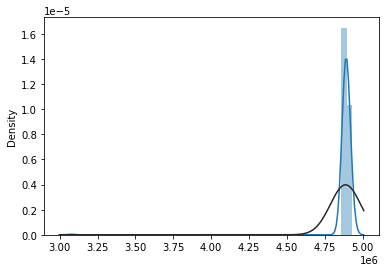

In [33]:
import seaborn as sns
from scipy.stats import norm, gamma
sns.distplot(costs_array_1, fit = norm)

In [34]:
costs_dataframe_1 = pd.read_csv('costs1.csv', delimiter = ' ')
costs_dataframe_1

,cost
0,4.884994e+06
1,4.904356e+06
2,4.914772e+06
3,4.927310e+06
4,4.879127e+06
...,...
995,4.905990e+06
996,4.884222e+06
997,4.883724e+06
998,4.879246e+06


/Users/harshal/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cost'>

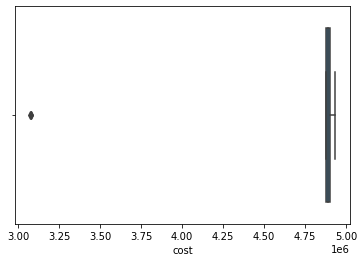

In [35]:
# Detecting the outliers
import seaborn as sns
sns.boxplot(costs_dataframe_1['cost'])

In [36]:
# Position of the Outlier
print(np.where(costs_dataframe_1['cost'] < 4750000))

(array([347, 467, 530]),)


In [37]:
# Removing the outliers
outliers_list = np.where(costs_dataframe_1['cost'] < 4750000)
costs_dataframe_1 = costs_dataframe_1.drop(list(outliers_list[0]))             
costs_dataframe_1

,cost
0,4.884994e+06
1,4.904356e+06
2,4.914772e+06
3,4.927310e+06
4,4.879127e+06
...,...
995,4.905990e+06
996,4.884222e+06
997,4.883724e+06
998,4.879246e+06


/Users/harshal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
100%|██████████| 1000/1000 [26:29<00:00,  1.59s/it]


<AxesSubplot:xlabel='cost', ylabel='Density'>

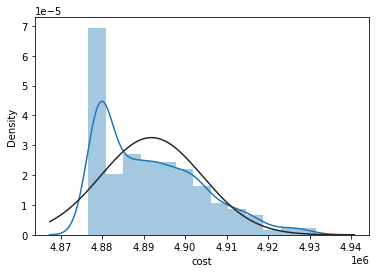

In [38]:
# New Plot after removing outliers
import seaborn as sns
from scipy.stats import norm, gamma
sns.distplot(costs_dataframe_1['cost'], fit = norm)

### New VaR (Value at Risk)

/Users/harshal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


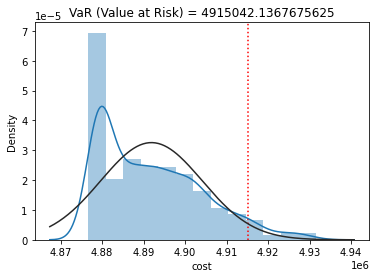

In [39]:
plt.axvline(np.percentile(np.sort(costs_dataframe_1['cost']), 95), color = 'red', linestyle = 'dotted')
cost_array_series_1 = pd.Series(costs_dataframe_1['cost'], name = 'cost')
sns.distplot(cost_array_series_1, fit = norm)
plt.title('VaR (Value at Risk) = ' + str(np.percentile(np.sort(costs_dataframe_1['cost']), 95)))
plt.show()

### Differences in VaR (Value at Risk)

In [45]:
difference_in_var = np.percentile(np.sort(costs_dataframe['cost']), 95) - np.percentile(np.sort(costs_dataframe_1['cost']), 95)
print('VaR decreases. It decreases by {}'.format(difference_in_var))

VaR decreases. It decreases by 473922.35495804716


#### The VaR value has decreased after changing the max power capacity of optimal generators

## Extra Extra Credit

Steps to create Model 'Extra Extra Credit': <br>
#### IMPORTANT NOTE : 
#### - NonConvex param is set to 2 (Since the Objective is not Positive semi-definite)
#### - We use the interior point method / barrier method instead of simplex
#### - We also use MIP (most important parameters) and set it to 0.05 for faster computation

1. Initialising the model 

2. Adding variables (Variables are power through a branch, phase angle (θ), generation units (Γ) and shed (S))
- We initialise the dictionary for each of the above variables
- Key of the dictionary is the name of the variable (For example : for 'power' variable, power_ + branch name (power_0 for branch '0'). Similarly, phase_angle_0 for node '0' and gamma_0 for generator named '0'
- Value of the dictionary are the variables to be identified that would optimise the objective function.

3. In addition to the above Step 2, we will also add variables (binary) for the generators whose power we can increase
- It is a dictionary with generator name as the key and binary values (0/1) as the indicators if we are increasing that generator's max power capacity (wind generators are excluded)

4. We will also add one more variable type which is a multiplication of two decision variables (generation units and the above defined indicator variable).
- This step is done as Gurobi doesn't allow optimisation of cubic variables


5. Defining objective function
a) Σg (σgpmaxg + 4σg(Γg − pmaxg)^2) (For generators whose max power is increased and whose power lies between pmaxg to 2 x pmaxg) <br>
b) Σg (σgΓg) (Sum of unit cost of generator (σ) and generation units (Γ) of each generator) (For generators whose max power isn't changed) <br>
c) (σg x pmaxg)/10 (Additional Expense to increase power of generators) <br>
d) 10^6 Σi Si (Shed value of all the generators) <br>
- Objective = 5a + 5b + 5c + 5d (Sum of all the above)


6. Defining target (Maximise / Minimise)
- Minimising the above objective function

7. Adding Constraints <br>
a) 0 ≤ Γg ≤ pmaxg (Constraint is skipped if generator is 'wind' operated) <br>
b) pmaxg ≤ Γg ≤ 2pmaxg (For generators whose power is increased) <br>
(generation units should be less than max power capacity of the generator) <br>
c) Maximum number of generators whose power can be increased is at most 10 <br>
d) pb = (θi−θj)/xb (power through a branch equals difference in phases at end nodes of the branch divided by the branch reactance) <br>
e) |pb| ≤ ub (power flow through a branch is less than the branch limit) <br>
f) Σ pb ( b  ∈  F (i) ) − Σ pb  ( b  ∈  T(i) ) = Σ ( g  ∈  G(i) )   Γg − (di−Si) <br>
(net amount of power injected by the bus i into the system is constant) <br>
g) 0 ≤ Si ≤ di <br>

In [47]:
from gurobipy import *

try:
    # STEP 1 : Create a new model
    m = Model('Extra Extra Credit')
    m.Params.LogToConsole = 0
    m.params.NonConvex = 2 ### IMPORTANT
    m.Params.MIPGap = 0.05 ### IMPORTANT
    m.Params.Method = 2 ### IMPORTANT
    m.tune()

    # STEP 2: Adding variables
    branches_list = set(branches_dataframe['branch'].values)
    power = dict()
    for branch in branches_list:
        power[branch] = m.addVar(vtype = GRB.CONTINUOUS, name = 'power_' + str(branch), lb = -GRB.INFINITY)

    nodes_list = set(buses_dataframe['bus'].values)
    phase_angle = dict()
    for node in nodes_list:
        phase_angle[node] = m.addVar(vtype = GRB.CONTINUOUS, name = 'phase_angle_' + str(node), lb = -GRB.INFINITY)

    generators_list = set(generators_dataframe['generator'].values)
    generation_units = dict()
    
    new_power_capacity_generators = dict()
    new_mixed_variable = dict()
    total_binary = []

    wind_generators_array = np.array(wind_dataframe['generator'])

    for generator_ in generators_list:
        generation_units[generator_] = m.addVar(vtype = GRB.CONTINUOUS, name = 'gamma_' + str(generator_))

        # STEP 3 : Indicator variable for generators whose power is to be increased
        if generator_ not in wind_generators_array:
            new_power_capacity_generators[generator_] = m.addVar(vtype = GRB.BINARY, name = 'generator_power_upgrade_' + str(generator_))
        else:
            new_power_capacity_generators[generator_] = m.addVar(vtype = GRB.INTEGER, lb = 0, ub = 0, name = 'generator_power_upgrade_' + str(generator_))
        
        # STEP 4 : Another variable as multiplication of 2 decision variables
        new_mixed_variable[generator_] = m.addVar(vtype = GRB.CONTINUOUS, name = 'new_mixed_variable_' + str(generator_))

    m.update()


    shed = dict()
    for node in nodes_list:
        shed[node] = m.addVar(name = 'shed_' + str(node))

    # Integrate new variables
    m.update()

    # STEP 5 : Defining objective function

    cost_per_generator_list = []
    additional_cost = []

    # STEP 5a and 5b
    for g in generators_list:
        value_1 = (get_unit_cost_of_generator(g)*generation_units[g])*(1 - new_power_capacity_generators[g])
        value_2 = get_unit_cost_of_generator(g) * get_max_power_from_generator(g)*new_power_capacity_generators[g]
        value_3 = 4 * new_power_capacity_generators[g] * get_unit_cost_of_generator(g) * (get_max_power_from_generator(g))**2
        value_4 = -8 * new_mixed_variable[g] * get_unit_cost_of_generator(g) * get_max_power_from_generator(g)
        value_5 = 4 * new_mixed_variable[g] * get_unit_cost_of_generator(g) * generation_units[g]
        total_value = value_1 + value_2 + value_3 + value_4 + value_5
        cost_per_generator_list.append(total_value)

        # STEP 5c
        additional_cost_value = (get_unit_cost_of_generator(g)*get_max_power_from_generator(g)/10)*new_power_capacity_generators[g]
        additional_cost.append(additional_cost_value)

    # STEP 5d
    shed_at_nodes = [shed[node] for node in nodes_list]
    objective = sum(cost_per_generator_list) + 1e6*sum(shed_at_nodes) + sum(additional_cost)

    # STEP 6 : Defining target
    m.setObjective(objective, GRB.MINIMIZE)

    # STEP 7 : Adding Constraints

    # STEP 7a and 7b
    for generator_ in generators_list:
        if generator_ in wind_generators_array: # The Skipping Portion
            continue

        # Left bound
        m.addConstr(new_power_capacity_generators[generator_]*get_max_power_from_generator(generator_) <=  generation_units[generator_], name = 'max_power_left_bound_' + str(generator_))
        
        # Right bound
        m.addConstr(generation_units[generator_] <= (1 + new_power_capacity_generators[generator_])*get_max_power_from_generator(generator_), name = 'max_power_right_bound_' + str(generator_))

    # STEP 7c
    for generator_ in generators_list:
        total_binary.append(new_power_capacity_generators[generator_])
    
    m.addConstr(sum(total_binary) <= 10)

    # Constraint that new variable is multiplication of 2 decision variables
    for generator_ in generators_list:
        m.addConstr(new_mixed_variable[generator_] == new_power_capacity_generators[generator_]*generation_units[generator_], name = 'new_mixed_variable_constraint_' + str(generator_))


    # STEP 7d
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] == get_power_flow_through_a_branch(branch, phase_angle_i, phase_angle_j), name = 'power_flow_' + str(branch))

    # STEP 7e
    for branch in branches_list:
        from_node, to_node = get_nodes_info_from_branch(branch)
        phase_angle_i = phase_angle[from_node]
        phase_angle_j = phase_angle[to_node]
        m.addConstr(power[branch] <= get_max_power_flow_through_branch(branch), name = 'branch_limit_pos' + str(branch))
        m.addConstr(power[branch] >= -get_max_power_flow_through_branch(branch), name = 'branch_limit_neg' + str(branch))

    # STEP 7f
    for node in nodes_list:
        from_branches = get_branches_associated_with_node(node)[1]
        from_power = [power[branch] for branch in from_branches]
        to_branches = get_branches_associated_with_node(node)[0]
        to_power = [power[branch] for branch in to_branches]
        generators = get_all_generators_at_node(node)

        m.addConstr(sum(from_power) - sum(to_power) == sum([generation_units[generator_] for generator_ in generators]) - (get_load_at_node(node) - shed[node]), name = 'power_balance_' + str(node))

    # STEP 7g : Additional shed constraint
    for node in nodes_list:
        m.addConstr(shed[node] <= get_load_at_node(node), name = 'shed_const_' + str(node))

except GurobiError:
    print('Error reported')

Optimize a model with 0 rows, 0 columns and 0 nonzeros
Model fingerprint: 0xf9715da1
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolve: All rows and columns removed
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


In [48]:
# Save costs to csv file
# Skip if reading costs from csv file

from tqdm import tqdm # For creating progress meters / progress bars

n = 50
objective_list = []
nodes_list = set(buses_dataframe['bus'].values)
#bar = progressbar.ProgressBar(maxval = n).start()

pbar = tqdm(total = n)
for i in tqdm(range(n)):
    sample_wind = sample_output_for_wind_generator()
    for i, g in enumerate(wind_generators_array):
        generation_units[g].lb = sample_wind[i]
        generation_units[g].ub = sample_wind[i]

    m.update()
    m.optimize()
    print('Model status: ' + str(m.status))
    # Check if model is feasible
    if m.status != 2:
        continue
        
    objective_list.append(m.objVal)
    
try:
    print(sum(objective_list)/len(objective_list))
    
except:
    print("Didn't get the optimised model in {} iterations".format(n))


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:34<28:32, 34.95s/it]

Model status: 2




  4%|▍         | 2/50 [01:02<26:11, 32.75s/it]

Model status: 2




  6%|▌         | 3/50 [01:41<27:11, 34.71s/it]

Model status: 2




  8%|▊         | 4/50 [02:16<26:31, 34.60s/it]

Model status: 2




 10%|█         | 5/50 [02:54<26:52, 35.83s/it]

Model status: 2




 12%|█▏        | 6/50 [03:22<24:23, 33.25s/it]

Model status: 2




 14%|█▍        | 7/50 [03:52<23:12, 32.38s/it]

Model status: 2




 16%|█▌        | 8/50 [04:25<22:51, 32.66s/it]

Model status: 2




 18%|█▊        | 9/50 [04:57<22:05, 32.32s/it]

Model status: 2




 20%|██        | 10/50 [05:27<21:02, 31.56s/it]

Model status: 2




 22%|██▏       | 11/50 [06:01<21:05, 32.44s/it]

Model status: 2




 24%|██▍       | 12/50 [06:31<19:58, 31.54s/it]

Model status: 2




 26%|██▌       | 13/50 [07:01<19:17, 31.28s/it]

Model status: 2




 28%|██▊       | 14/50 [07:33<18:51, 31.43s/it]

Model status: 2




 30%|███       | 15/50 [08:03<18:02, 30.94s/it]

Model status: 2




 32%|███▏      | 16/50 [08:32<17:16, 30.49s/it]

Model status: 2




 34%|███▍      | 17/50 [09:01<16:32, 30.07s/it]

Model status: 2




 36%|███▌      | 18/50 [09:29<15:41, 29.41s/it]

Model status: 2




 38%|███▊      | 19/50 [09:57<15:00, 29.06s/it]

Model status: 2




 40%|████      | 20/50 [10:27<14:40, 29.34s/it]

Model status: 2




 42%|████▏     | 21/50 [10:57<14:14, 29.47s/it]

Model status: 2




 44%|████▍     | 22/50 [11:25<13:31, 28.99s/it]

Model status: 2




 46%|████▌     | 23/50 [11:46<11:57, 26.58s/it]

Model status: 2




 48%|████▊     | 24/50 [12:16<11:58, 27.63s/it]

Model status: 2




 50%|█████     | 25/50 [12:43<11:22, 27.28s/it]

Model status: 2




 52%|█████▏    | 26/50 [13:11<11:05, 27.74s/it]

Model status: 2




 54%|█████▍    | 27/50 [13:38<10:32, 27.50s/it]

Model status: 2




 56%|█████▌    | 28/50 [14:07<10:10, 27.76s/it]

Model status: 2




 58%|█████▊    | 29/50 [14:35<09:44, 27.83s/it]

Model status: 2




 60%|██████    | 30/50 [14:36<06:36, 19.83s/it]

Model status: 2




 62%|██████▏   | 31/50 [15:03<06:59, 22.08s/it]

Model status: 2




 64%|██████▍   | 32/50 [15:35<07:30, 25.03s/it]

Model status: 2




 66%|██████▌   | 33/50 [16:03<07:18, 25.79s/it]

Model status: 2




 68%|██████▊   | 34/50 [16:30<07:01, 26.31s/it]

Model status: 2




 70%|███████   | 35/50 [16:58<06:41, 26.77s/it]

Model status: 2




 72%|███████▏  | 36/50 [17:31<06:43, 28.79s/it]

Model status: 2




 74%|███████▍  | 37/50 [18:10<06:51, 31.63s/it]

Model status: 2




 76%|███████▌  | 38/50 [18:43<06:25, 32.11s/it]

Model status: 2




 78%|███████▊  | 39/50 [19:45<07:31, 41.06s/it]

Model status: 2




 80%|████████  | 40/50 [20:20<06:32, 39.29s/it]

Model status: 2




 82%|████████▏ | 41/50 [20:51<05:31, 36.85s/it]

Model status: 2




 84%|████████▍ | 42/50 [21:21<04:37, 34.63s/it]

Model status: 2




 86%|████████▌ | 43/50 [21:49<03:48, 32.64s/it]

Model status: 2




 88%|████████▊ | 44/50 [22:18<03:10, 31.68s/it]

Model status: 2




 90%|█████████ | 45/50 [22:53<02:42, 32.56s/it]

Model status: 2




 92%|█████████▏| 46/50 [23:25<02:09, 32.40s/it]

Model status: 2




 94%|█████████▍| 47/50 [23:55<01:34, 31.61s/it]

Model status: 2




 96%|█████████▌| 48/50 [24:26<01:02, 31.47s/it]

Model status: 2




 98%|█████████▊| 49/50 [24:59<00:32, 32.17s/it]

Model status: 2




100%|██████████| 50/50 [25:40<00:00, 30.82s/it]

Model status: 2
586848.2070472378


In [51]:
print('Expectation of minimum total cost (operational plus expansion cost) is {}'.format(sum(objective_list)/len(objective_list)))

Expectation of minimum total cost (operational plus expansion cost) is 586848.2070472378
